# Evaluating LLM Variants on the Deep Learning Domain

### Set up the notebook environment

In [ ]:
# !pip install -q -U bitsandbytes
# !pip install -q -U pip
# !pip install -q -U datasets
# !pip install -q -U accelerate
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
# !pip install -q -U einops
# !pip install -q -U safetensors
# !pip install -q -U torch
# !pip install -q -U xformers
# !pip install -q -U langchain
# !pip install -q -U pypdf
# !pip install -q -U pymupdf
# !pip install -q -U faiss-gpu
# !pip install -q -U bert_score
# !pip install -q -U spacy
# !pip install -q typing-inspect==0.8.0
# !pip install -q typing_extensions==4.5.0
# !pip install -q pydantic==1.10.11

In [1]:
import os
import logging
import transformers
import bert_score
import torch
import pandas as pd
import bitsandbytes as bnb
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import rcParams
from bert_score import score, BERTScorer
from datasets import load_dataset
from operator import itemgetter
from langchain import HuggingFacePipeline
from langchain import PromptTemplate
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader, DirectoryLoader
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
    pipeline,
)

## just to suppress warnings for things like not running on GPU when using langchain
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)


if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else :
    device = torch.device('cpu')

device

ModuleNotFoundError: ignored

In [1]:
import os

### Set up constants to manage local storage and retrieve models and data

In [2]:
PROJECT_ROOT = '.'
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')

PDF_DIR = os.path.join(PROJECT_ROOT, DATA_DIR, 'pdfs')
TEXT_DIR = os.path.join(PROJECT_ROOT, DATA_DIR, 'texts')

MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')

TRAIN_DATA_SOURCE = 'mjphayes/textbook_dataset'
TRAIN_DATA_CACHE = os.path.join(PROJECT_ROOT, DATA_DIR, 'textbook-dataset')

EVAL_DATA_SOURCE = 'mjphayes/machine_learning_questions'
EVAL_DATA_CACHE = os.path.join(PROJECT_ROOT, DATA_DIR, 'machine-learning-questions')

GPT2_CHECKPOINT = 'distilgpt2'
GPT2_CACHE_DIR = os.path.join(PROJECT_ROOT, MODELS_DIR, GPT2_CHECKPOINT)

GPT2_FINETUNE_CHECKPOINT = 'mjphayes/distilgpt2-finetuned-textbook_dataset'
GPT2_FINETUNE_CACHE_DIR = os.path.join(PROJECT_ROOT, MODELS_DIR, 'distilgpt2-finetuned-textbook_dataset')

FALCON_CHECKPOINT = "vilsonrodrigues/falcon-7b-instruct-sharded"
FALCON_CACHE_DIR = os.path.join(PROJECT_ROOT, MODELS_DIR, 'falcon-7b-instruct')

FALCON_FINETUNE_CHECKPOINT = 'mjphayes/falcon-7b-instruct-textbook_dataset'
FALCON_FINETUNE_CACHE_DIR = os.path.join(PROJECT_ROOT, MODELS_DIR, 'falcon-7b-instruct-textbook_dataset')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
if not os.path.exists(PDF_DIR):
    os.makedirs(PDF_DIR)
if not os.path.exists(TEXT_DIR):
    os.makedirs(TEXT_DIR)

In [ ]:
# HF_TOKEN = os.environ.get('HF_TOKEN')

## Generating the two custom domain specific datasets

In [ ]:
!wget https://everythingcomputerscience.com/books/Machine%20Learning%20for%20Humans.pdf -P $PDF_DIR
!wget https://mml-book.github.io/book/mml-book.pdf -P $PDF_DIR
!wget https://github.com/abhishekkrthakur/approachingalmost/raw/master/AAAMLP.pdf -P $PDF_DIR
!wget https://people.smp.uq.edu.au/DirkKroese/DSML/DSML.pdf -P $PDF_DIR
!wget https://raw.githubusercontent.com/janishar/mit-deep-learning-book-pdf/master/complete-book-pdf/deeplearningbook.pdf -P $PDF_DIR

### Extracting raw text from the textbooks

In [ ]:
def extract_pdf_text(filename):
    file = open(filename, 'rb')
    reader = PyPDF2.PdfReader(file)
    text = ''
    for page in range(len(reader.pages)):
        page = reader.pages[page]
        text += page.extract_text()
    return text

In [ ]:
def extract_pdf_text_from_dir(dir):
    text = ''
    for filename in glob.glob(os.path.join(PDF_DIR, '*.pdf')):
        text += extract_pdf_text(filename) + '\n\n\n\n\n'
    return text

In [ ]:
texts = extract_pdf_text_from_dir(PDF_DIR)
file = open(os.path.join(TEXT_DIR, 'combined_textbooks.txt'), 'w')
file.write(texts)

### Creating the huggingface datasets datamodel from the raw text

In [ ]:
dataset = load_dataset('text', data_files=os.path.join(TEXT_DIR, 'combined_textbooks.txt'))
dataset

In [ ]:
# dataset.push_to_hub(TRAIN_DATA_SOURCE, use_auth_token=HF_TOKEN)

In [ ]:
path_to_texts = os.path.join(DATA_DIR, 'textbooks.txt')
try:
    text_books = open(path_to_texts, 'r', encofing="utf-8").read()
except:
    !wget 'https://gist.githubusercontent.com/mitchelljphayes/82de40eb4ec9275c9b3403fa53665fde/raw/88b0d35d78b4b65d02384980b3e106f20767f7c6/textbooks.txt' -P $DATA_DIR
    text_books = open(path_to_texts, 'r', encoding="utf-8").read()

## Creating the custom Question Answer dataset

In [ ]:
path_to_questions = os.path.join(DATA_DIR, 'machine-learning-questions.json')
try:
    questions = pd.read_json(path_to_questions)
except:
    !wget https://gist.githubusercontent.com/mitchelljphayes/7cb8fafc2959f2ef2d54020e70ff5283/raw/f93ca8dd70378fb434fa5acb3fc69e27ed54b05e/machine-learning-questions.json -P $DATA_DIR
    questions = pd.read_json(path_to_questions)

## Evaluating sentence similarity evaluations using BertScore


In [ ]:
scorer = BERTScorer(lang="en")
def evaluate_answers(dataset, generated_answers, scorer=scorer):
    ideal = dataset['answer']
    P, R, F1 = scorer.score(ideal, generated_answers)
    df = pd.DataFrame({'question': dataset['question'], 'ideal': ideal, 'generated': generated_answers, 'P': P, 'R': R, 'F1': F1})
    return df

## Falcon 7 B

### Initialising the baseline falcon-7b-instruct model

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
falcon_4bit = AutoModelForCausalLM.from_pretrained(
        FALCON_CHECKPOINT,
        device_map='auto',
        quantization_config=quantization_config,
        cache_dir=FALCON_CACHE_DIR,
        )
falcon_tokenizer = AutoTokenizer.from_pretrained(FALCON_CHECKPOINT, cache_dir=FALCON_CACHE_DIR)

In [ ]:
falcon_tokenizer.pad_token = falcon_tokenizer.eos_token

In [ ]:
def print_trainable_parameters(model):
  """
  Prints the number of trainable parameters in the model.
  """
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} || all params: {all_param} || trainables%: {100 * trainable_params / all_param}"
  )

In [ ]:
falcon_4bit.gradient_checkpointing_enable()
falcon_4bit = prepare_model_for_kbit_training(falcon_4bit)

In [ ]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

falcon_4bit = get_peft_model(falcon_4bit, config)
print_trainable_parameters(falcon_4bit)

In [ ]:
    generation_config = falcon_4bit.generation_config
    generation_config.max_new_tokens = 312
    generation_config.temperature = 0.7
    generation_config.top_p = 0.7
    generation_config.num_return_sequences = 1
    generation_config.pad_token_id = falcon_tokenizer.eos_token_id
    generation_config.eos_token_id = falcon_tokenizer.eos_token_id

In [ ]:
prompt = """
Question: What is machine learning?
Answer:
""".strip()
%time
encoding = falcon_tokenizer(prompt, return_tensors="pt").to(device)
with torch.no_grad():
  outputs = falcon_4bit.generate(
      input_ids = encoding.input_ids,
      attention_mask = encoding.attention_mask,
      generation_config = generation_config
  )

print(falcon_tokenizer.decode(outputs[0], skip_special_tokens=True))

## Evaluating the baseline falcon model

In [ ]:
def falcon_inference(question, model, tokenizer, device):
    prompt = f"""
    Question: {question}
    Answer:
    """.strip()
    generation_config = model.generation_config
    generation_config.max_new_tokens = 312
    generation_config.temperature = 0.7
    generation_config.top_p = 0.7
    generation_config.num_return_sequences = 1
    generation_config.pad_token_id = tokenizer.eos_token_id
    generation_config.eos_token_id = tokenizer.eos_token_id

    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = model.generate(
          input_ids = encoding.input_ids,
          attention_mask = encoding.attention_mask,
          generation_config = generation_config
      )
    initial_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = initial_answer.split('Answer:')[-1]
    return answer.strip()

In [ ]:
def run_evaluation(evaluation_dataset, inference_function, model, tokenizer, device):
    results = []
    for i in tqdm(range(len(evaluation_dataset))):
        question = evaluation_dataset[i]['question']
        answer = inference_function(question, model, tokenizer, device)
        results.append(answer)
    return results

In [ ]:
eval_data = load_dataset(EVAL_DATA_SOURCE, cache_dir=EVAL_DATA_CACHE, split='train')

In [ ]:
answer = falcon_inference('What is machine learning?', falcon_4bit, falcon_tokenizer, device)
answer

In [ ]:
falcon_answers = run_evaluation(eval_data, falcon_inference, falcon_4bit, falcon_tokenizer, device)

In [ ]:
falcon_results = evaluate_answers(eval_data, falcon_answers)
falcon_results.to_csv(os.path.join(RESULTS_DIR, 'falcon_results.csv'))

## Fine tuning falcon

In [ ]:
textbook_dataset = load_dataset(TRAIN_DATA_SOURCE, cache_dir=TRAIN_DATA_CACHE)

In [ ]:
def tokenize_for_falcon(examples):
    return falcon_tokenizer(examples["text"])

In [ ]:
tokenized_text = textbook_dataset.map(tokenize_for_falcon, batched=True, num_proc=4, remove_columns=["text"])

In [ ]:
split_data = tokenized_text['train'].train_test_split(test_size=0.05)

In [ ]:
block_size = falcon_tokenizer.model_max_length
# block_size = 128
block_size

In [ ]:
def group_inputs(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
grouped_data = split_data.map(
    group_inputs,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

In [ ]:
grouped_data

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=8,
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    fp16=True,
    save_total_limit=3,
    logging_steps=1,
    output_dir="experiments",
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
)

trainer = Trainer(
    model=falcon_4bit,
    train_dataset=grouped_data['train'],
    eval_dataset=grouped_data['test'],
    args=training_args,
    data_collator=DataCollatorForLanguageModeling(falcon_tokenizer, mlm=False)
)
falcon_4bit.config.use_cache = False

In [ ]:
trainer.train()

In [ ]:
trainer.save_model(FALCON_FINETUNE_CHECKPOINT)

In [ ]:
try:
    falcon_finetune = falcon_4bit
except:
    falcon_finetune = AutoModelForCausalLM.from_pretrained(
        FALCON_FINETUNE_CHECKPOINT,
        quantization_config=quantization_config,
        cache_dir=FALCON_FINETUNE_CACHE_DIR,
        device_map='auto'
        )

In [ ]:
def generate_prompt(data_point):
  return f"""
Question: {data_point["question"]}
Answer: {data_point["answer"]}
""".strip()

def generate_and_tokenize_prompt(data_point):
  full_prompt = generate_prompt(data_point)
  tokenized_full_prompt = falcon_tokenizer(full_prompt, padding=True, truncation=True)
  return tokenized_full_prompt

In [ ]:
alignment_data = load_dataset(EVAL_DATA_SOURCE, cache_dir=EVAL_DATA_CACHE, split='test')

In [ ]:
alignment_data = alignment_data.map(generate_and_tokenize_prompt).remove_columns(['question', 'answer']).train_test_split(test_size=0.05)

In [ ]:
alignment_data

In [ ]:
alignment_trainer = transformers.Trainer(
    model=falcon_finetune,
    train_dataset=alignment_data['train'],
    eval_dataset=alignment_data['test'],
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(falcon_tokenizer, mlm=False)
)
falcon_finetune.config.use_cache = False

In [ ]:
alignment_trainer.train()

In [ ]:
falcon_finetune.save_pretrained(FALCON_FINETUNE_CACHE_DIR)
falcon_tokenizer.save_pretrained(FALCON_FINETUNE_CACHE_DIR)
# falcon_finetune.push_to_hub(FALCON_FINETUNE_CHECKPOINT, token=HF_TOKEN)
# falocn_tokenizer.push_to_hub(FALCON_FINETUNE_CHECKPOINT, token=HF_TOKEN)

We now reload the model into memory, so that it is configured for inference, and we have a point at which we can run the notebook, to skip the training step.

In [ ]:
falcon_finetune = AutoModelForCausalLM.from_pretrained(FALCON_FINETUNE_CHECKPOINT, cache_dir=FALCON_FINETUNE_CACHE_DIR, device_map='auto', quantization_config=quantization_config)

### Evaluating the finetuned falcon model

In [ ]:
prompt = """
Questin: What is an LSTM?
Answer:
""".strip()

encoding = falcon_tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
# with torch.no_grad():
  outputs = falcon_finetune.generate(
      input_ids = encoding.input_ids,
      attention_mask = encoding.attention_mask,
      generation_config = generation_config
  )
print(falcon_tokenizer.decode(outputs[0], skip_special_tokens=True))

In [ ]:
answer = falcon_inference("What is an LSTM", falcon_finetune, falcon_tokenizer, device)
answer

In [ ]:
falcon_finetune_answers = run_evaluation(eval_data, falcon_inference, falcon_finetune, falcon_tokenizer, device)

In [ ]:
falcon_finetune_results = evaluate_answers(eval_data, falcon_finetune_answers)
falcon_finetune_results.to_csv(os.path.join(RESULTS_DIR, 'falcon_finetune_results.csv'))

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

# Loading GPT2

In [ ]:
gpt2 = AutoModelForCausalLM.from_pretrained(GPT2_CHECKPOINT, cache_dir=GPT2_CACHE_DIR)
gpt2_tokenizer = AutoTokenizer.from_pretrained(GPT2_CHECKPOINT, cache_dir=GPT2_CACHE_DIR, use_fast=True)

In [ ]:
gpt2.to(device)

In [ ]:
special_tokens_dict = {'eos_token': '<|endoftext|>'}
num_added_toks = gpt2_tokenizer.add_special_tokens(special_tokens_dict)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2.resize_token_embeddings(len(gpt2_tokenizer))

In [ ]:
def gpt2_inference(question, model, tokenizer, device):
    prompt = f"""
    Question: {question} \n
    Answer:
    """.strip()
    model_inputs = tokenizer(prompt, return_tensors="pt").to(device)
    generated_tokens = model.generate(**model_inputs, max_length=512)
    response = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    answer = response.split('Answer:')[-1]
    return answer.strip()

In [ ]:
answer = gpt2_inference("Explain how neural networks work", gpt2, gpt2_tokenizer, device)
answer

In [ ]:
gpt2_answers = run_evaluation(eval_data, gpt2_inference, gpt2, gpt2_tokenizer, device)

In [ ]:
gpt2_results = evaluate_answers(eval_data, gpt2_answers)
gpt2_results.to_csv(os.path.join(RESULTS_DIR, 'gpt2_results.csv'))

# Finetuning GPT2

In [ ]:
textbook_dataset = load_dataset(TRAIN_DATA_SOURCE, cache_dir=TRAIN_DATA_CACHE)
textbook_dataset

In [ ]:
def tokenize_for_gpt2(examples):
    return gpt2_tokenizer(examples["text"])

In [ ]:
gpt2_tokenized_text = textbook_dataset.map(tokenize_for_gpt2, batched=True, num_proc=4, remove_columns=["text"])

In [ ]:
block_size = gpt2_tokenizer.model_max_length
block_size

In [ ]:
def group_inputs(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
grouped_text_data = gpt2_tokenized_text.map(
    group_inputs,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

In [ ]:
grouped_text_data = grouped_text_data['train'].train_test_split(test_size=0.05, shuffle=True)

In [ ]:
training_args = TrainingArguments(
    GPT2_FINETUNE_CACHE_DIR,
    evaluation_strategy="epoch",
    num_train_epochs=8,
    learning_rate=2e-4,
    weight_decay=0.01,
)
trainer = Trainer(
    model=gpt2,
    args=training_args,
    train_dataset=grouped_text_data['train'],
    eval_dataset=grouped_text_data['test'],
    data_collator=DataCollatorForLanguageModeling(gpt2_tokenizer, mlm=False),
)


In [ ]:
trainer.train()

In [ ]:
def transform_for_q_and_a(examples):
    return {"text": f"Question: {examples['question']} \n Answer: {examples['answer']}"}

In [ ]:
trainer.save_model(GPT2_FINETUNE_CACHE_DIR)
gpt2_tokenizer.save_pretrained(GPT2_FINETUNE_CACHE_DIR)
gpt2_finetune = AutoModelForCausalLM.from_pretrained(GPT2_FINETUNE_CHECKPOINT, cache_dir=GPT2_FINETUNE_CACHE_DIR)

In [ ]:
alignment_data = (load_dataset(EVAL_DATA_SOURCE, cache_dir=EVAL_DATA_CACHE, split='test')
                    .train_test_split(test_size=0.1, shuffle=True)
                    .map(transform_for_q_and_a, num_proc=4)
                    .map(tokenize_for_gpt2, batched=True, num_proc=4, remove_columns=["text"])
                    )



In [ ]:
training_args = TrainingArguments(
    GPT2_FINETUNE_CACHE_DIR,
    evaluation_strategy="epoch",
    num_train_epochs=8,
    learning_rate=2e-4,
    weight_decay=0.01,
)
alignment_trainer = Trainer(
    model=gpt2_finetune,
    args=training_args,
    train_dataset=alignment_data['train'],
    eval_dataset=alignment_data['test'],
    data_collator=DataCollatorForLanguageModeling(gpt2_tokenizer, mlm=False),
)

In [ ]:
alignment_trainer.train()

In [ ]:
alignment_trainer.save_model(GPT2_FINETUNE_CACHE_DIR)
gpt2_tokenizer.save_pretrained(GPT2_FINETUNE_CACHE_DIR)

In [ ]:
# gpt2.push_to_hub(GPT2_FINETUNE_CHECKPOINT, use_auth_token=HF_TOKEN)
# gpt2_tokenizer.push_to_hub(GPT2_FINETUNE_CHECKPOINT, use_auth_token=HF_TOKEN)

In [ ]:
gpt2_finetune = AutoModelForCausalLM.from_pretrained(GPT2_FINETUNE_CHECKPOINT, cache_dir=GPT2_FINETUNE_CACHE_DIR).to(device)

In [ ]:
gpt2_finetune_answers = run_evaluation(eval_data, gpt2_inference, gpt2_finetune, gpt2_tokenizer, device)

In [ ]:
gpt2_finetune_results = evaluate_answers(eval_data, gpt2_finetune_answers)
gpt2_finetune_results.to_csv(os.path.join(RESULTS_DIR, 'gpt2_finetune_results.csv'))

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

# Loading falcon for RAG

In [ ]:
rag_quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
falcon_4bit_rag = AutoModelForCausalLM.from_pretrained(
        FALCON_CHECKPOINT,
        device_map='auto',
        quantization_config=rag_quantization_config,
        cache_dir=FALCON_CACHE_DIR,
        )
falcon_tokenizer_rag = AutoTokenizer.from_pretrained(FALCON_CHECKPOINT, cache_dir=FALCON_CACHE_DIR)

In [ ]:
rag_pipeline = pipeline(
        "text-generation",
        model=falcon_4bit_rag,
        tokenizer=falcon_tokenizer_rag,
        use_cache=True,
        device_map="auto",
        max_length=2048,
        do_sample=True,
        top_k=3,
        num_return_sequences=1,
        eos_token_id=falcon_tokenizer_rag.eos_token_id,
        pad_token_id=falcon_tokenizer_rag.eos_token_id,
)

In [ ]:
text_books = open(path_to_texts, 'r', encoding="utf-8").read()

In [ ]:
rag_falcon = HuggingFacePipeline(pipeline=rag_pipeline)
rag_embeddings = HuggingFaceEmbeddings()

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=48,
    length_function=len,
    add_start_index=False,
)

In [ ]:
text_books = text_books.strip()
text_books

In [ ]:
texts = text_splitter.create_documents([text_books])

In [ ]:
embeddings = HuggingFaceEmbeddings()

In [ ]:
vector_store = FAISS.from_documents(texts, embeddings)
vector_store.save_local('./storage/vector_store')
vector_store = FAISS.load_local('./storage/vector_store', embeddings)
retriever = vector_store.as_retriever()

In [ ]:
search = vector_store.similarity_search("What is a neural network?", k=3)
source = search[0].page_content
source

In [ ]:
answer = retriever.get_relevant_documents("What is a neural network?", k=1)

In [ ]:
answer

In [ ]:
template = """Answer the question based only on the context provided bellow:

INSTRUCTIONS:
Ensure that the answer is grammatically correct and relevant to the context.
DO NOT include any HTML tags in your answer.
DO NOT include any information that is not directly relevant to the question.
Be succinct and to the point. Keep your answer to one or two sentences.

Context: {context}


Question: {question}


Answer:"""

prompt = ChatPromptTemplate.from_template(template)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
    }
    | prompt
    | rag_falcon
    | StrOutputParser()
)

In [ ]:
eval_data = load_dataset(EVAL_DATA_SOURCE, cache_dir=EVAL_DATA_CACHE, split='train')

In [ ]:
eval_data

In [ ]:
from random import randint
rand = randint(0, len(eval_data))
random_question = eval_data[rand]['question']
ideal_answer = eval_data[rand]['answer']
print(random_question)
generated_answer = chain.invoke({"question": random_question})
generated_answer = generated_answer.split('Answer: ')[-1].strip().split('\n')[0]
print(generated_answer)
print("="*86)
print(ideal_answer)

In [ ]:
def rag_inference(question, model, tokenizer, device):
    chain = model
    response = chain.invoke({"question": question})
    answer = response.split('Answer: ')[-1].strip().split('\n')[0]
    return answer

In [ ]:
rag_answers = run_evaluation(eval_data, rag_inference, chain, falcon_tokenizer_rag, device)

In [ ]:
rag_results = evaluate_answers(eval_data, rag_answers)
rag_results.to_csv(os.path.join(RESULTS_DIR, 'rag_results.csv'))

# Results

In [13]:
import numpy as np

In [4]:
gpt2_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'gpt2_results.csv'))
gpt2_finetune_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'gpt2_finetune_results.csv'))
falcon_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'falcon_results.csv'))
falcon_finetune_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'falcon_finetune_results.csv'))
rag_results_df = pd.read_csv(os.path.join(RESULTS_DIR, 'rag_results.csv'))

In [5]:
def print_summary(df, model_name):
    print(f"{model_name:20s} Mean Precision: {df['P'].mean()}")
    print(f"{model_name:20s} Mean Recall:    {df['R'].mean()}")
    print(f"{model_name:20s} Mean F1:        {df['F1'].mean()}")

In [6]:
models_with_results = {
    'GPT2': gpt2_results_df,
    'GPT2 Finetuned': gpt2_finetune_results_df,
    'FALCON': falcon_results_df,
    'FALCON Finetuned': falcon_finetune_results_df,
    'RAG': rag_results_df
}

In [7]:
for model_name, results_df in models_with_results.items():
    print("="*55)
    print_summary(results_df, model_name)
    print()

GPT2                 Mean Precision: 0.7444586824015748
GPT2                 Mean Recall:    0.6856828544488188
GPT2                 Mean F1:        0.7117185585826771

GPT2 Finetuned       Mean Precision: 0.48040724458661416
GPT2 Finetuned       Mean Recall:    0.474265110511811
GPT2 Finetuned       Mean F1:        0.4763223158464567

FALCON               Mean Precision: 0.8964403807874015
FALCON               Mean Recall:    0.8840705547244094
FALCON               Mean F1:        0.8898986018307087

FALCON Finetuned     Mean Precision: 0.8796251982283464
FALCON Finetuned     Mean Recall:    0.8074321935433071
FALCON Finetuned     Mean F1:        0.8404417248031497

RAG                  Mean Precision: 0.8948293111220472
RAG                  Mean Recall:    0.8682503328346457
RAG                  Mean F1:        0.8809914010629921



In [8]:
def show_f1_scores(df, model_name):
    plt.figure(figsize=(12, 8))
    plt.hist(df['F1'], bins=100)
    plt.title(f"{model_name} F1 Scores")
    plt.style.use('ggplot')
    plt.show()

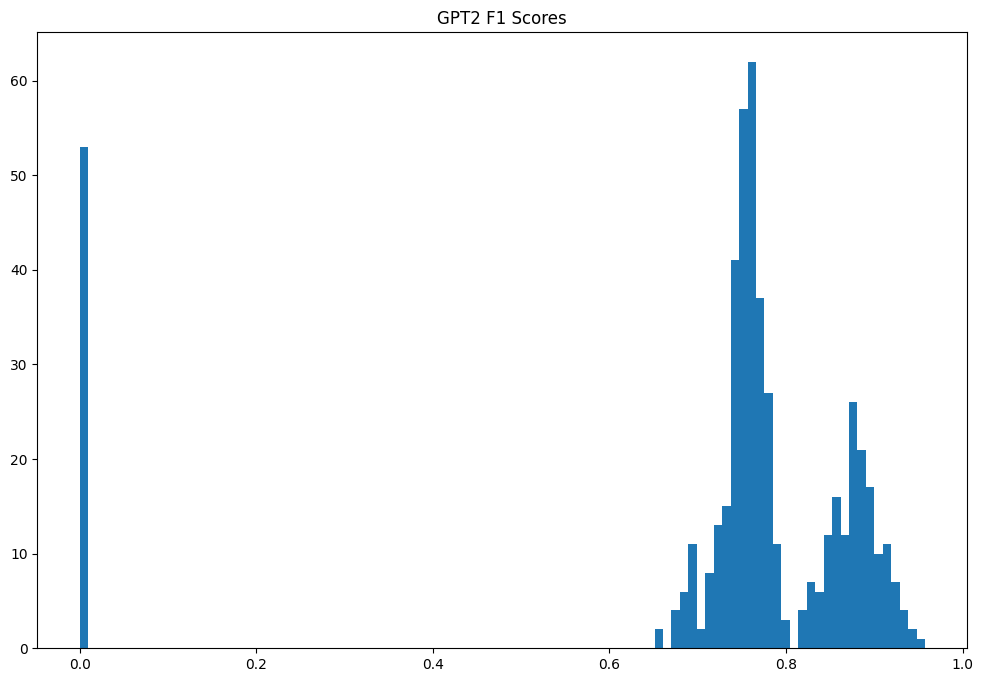

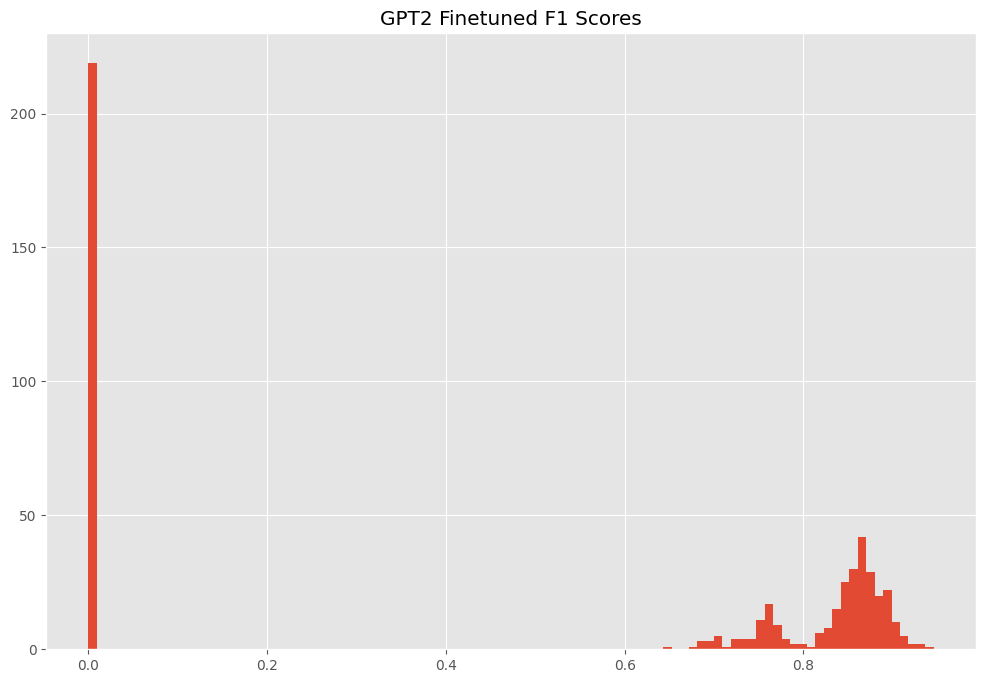

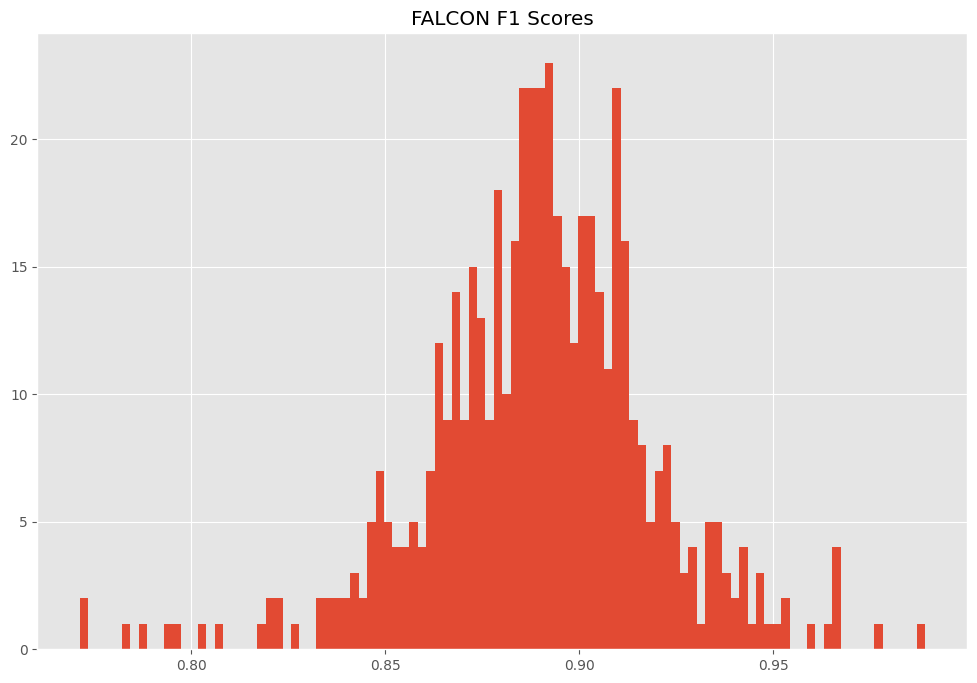

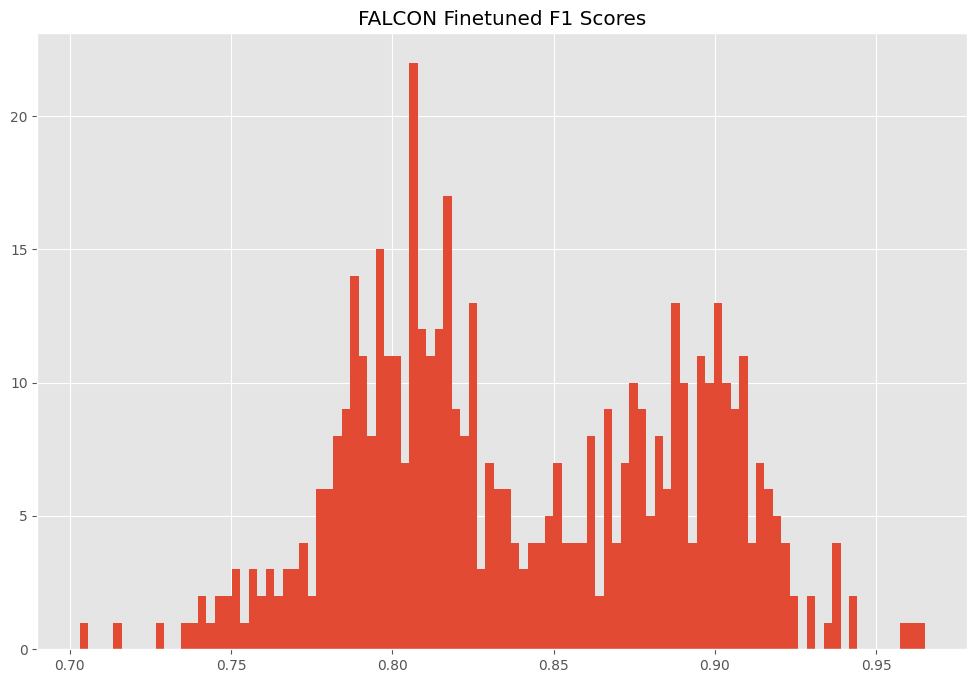

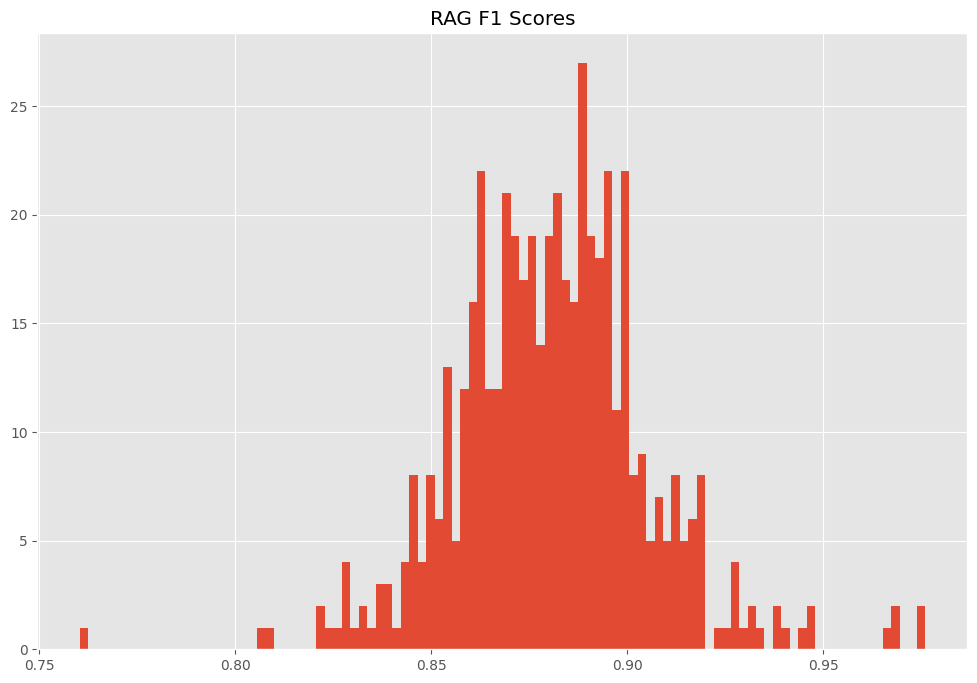

In [9]:
for model_name, results_df in models_with_results.items():
    show_f1_scores(results_df, model_name)

In [10]:
def show_average_scores(df, model_name):
    average_precision = df['P'].mean()
    average_recall = df['R'].mean()
    average_f1 = df['F1'].mean()

    scores = [average_precision, average_recall, average_f1]
    labels = ['Precision', 'Recall', 'F1 Score']
    plt.figure(figsize=(8, 6))
    barlist = plt.bar(labels, scores, color=['blue', 'green', 'red'])
    for idx, bar in enumerate(barlist):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{scores[idx]:.3f}', ha='center', va='bottom')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title(f'{model_name} Average Precision, Recall, and F1 Score')
    plt.style.use('ggplot')
    plt.show()

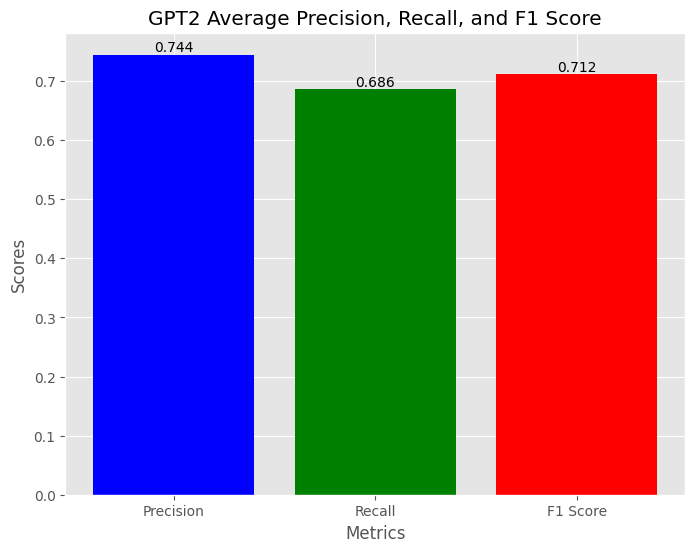

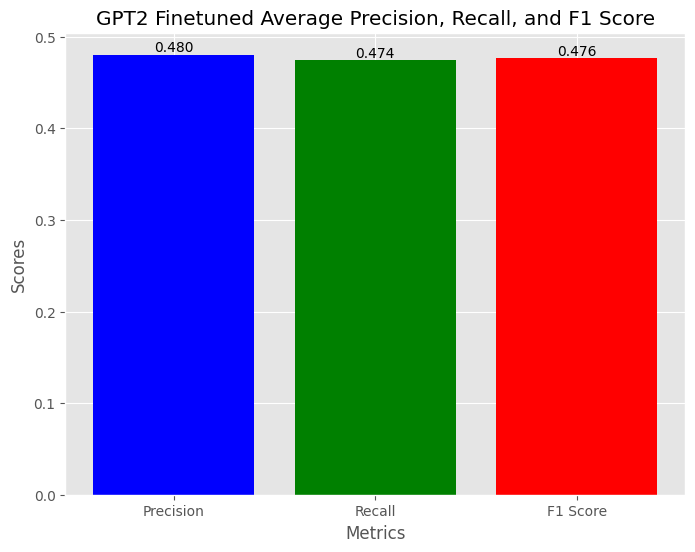

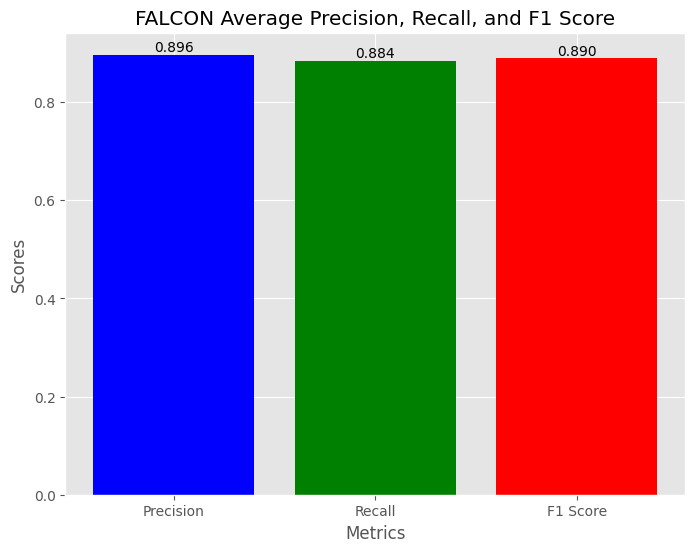

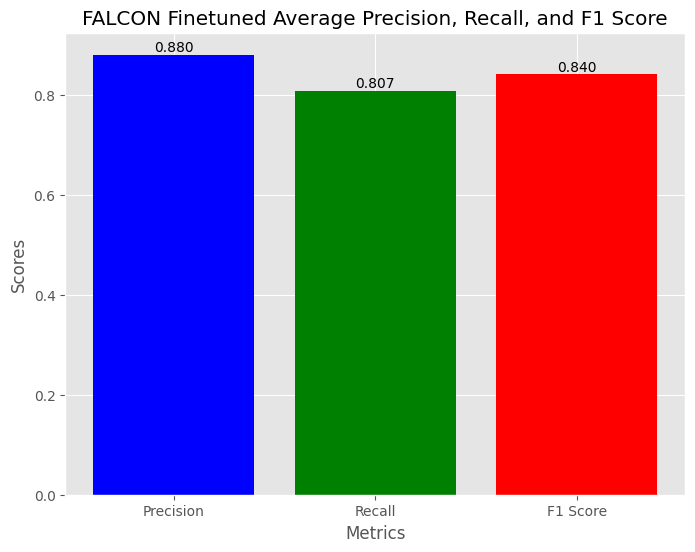

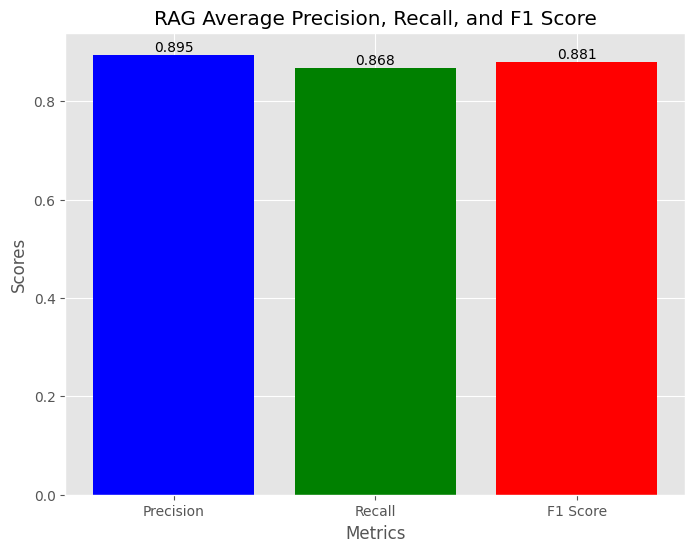

In [11]:
for model_name, results_df in models_with_results.items():
    show_average_scores(results_df, model_name)

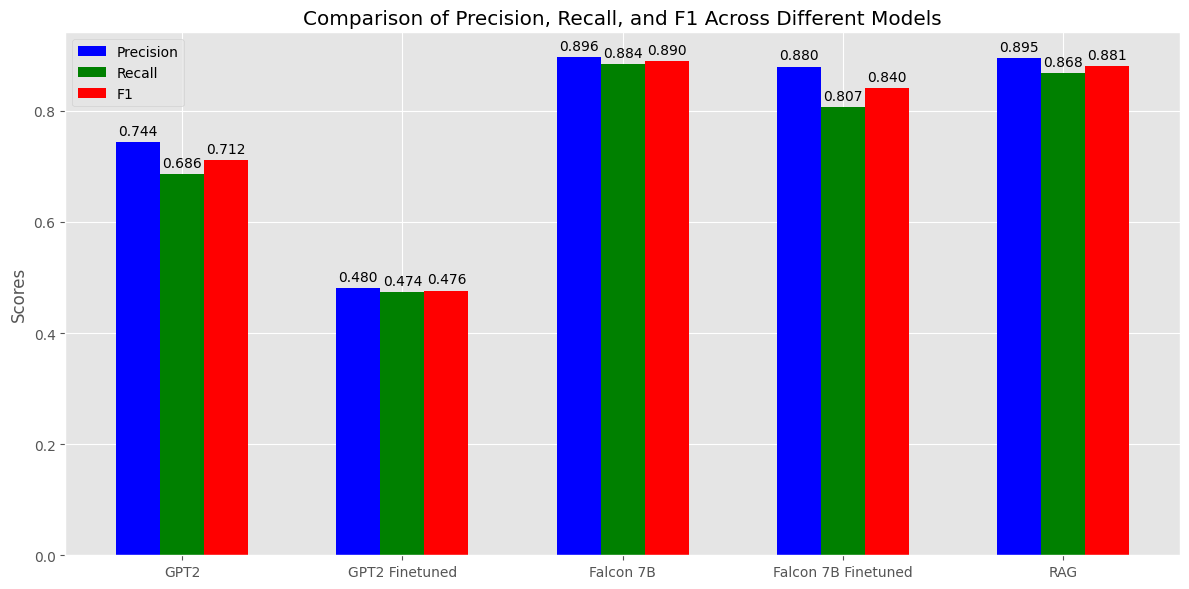

In [18]:

average_precision_gpt2 = gpt2_results_df['P'].mean()
average_recall_gpt2 = gpt2_results_df['R'].mean()
average_f1_gpt2 = gpt2_results_df['F1'].mean()

average_precision_gpt2_finetune = gpt2_finetune_results_df['P'].mean()
average_recall_gpt2_finetune = gpt2_finetune_results_df['R'].mean()
average_f1_gpt2_finetune = gpt2_finetune_results_df['F1'].mean()

average_precision_falcon = falcon_results_df['P'].mean()
average_recall_falcon = falcon_results_df['R'].mean()
average_f1_falcon = falcon_results_df['F1'].mean()

average_precision_falcon_finetune = falcon_finetune_results_df['P'].mean()
average_recall_falcon_finetune = falcon_finetune_results_df['R'].mean()
average_f1_falcon_finetune = falcon_finetune_results_df['F1'].mean()

average_precision_rag = rag_results_df['P'].mean()
average_recall_rag = rag_results_df['R'].mean()
average_f1_rag = rag_results_df['F1'].mean()


precisions = [average_precision_gpt2, average_precision_gpt2_finetune, average_precision_falcon, average_precision_falcon_finetune, average_precision_rag]
recalls = [average_recall_gpt2, average_recall_gpt2_finetune, average_recall_falcon, average_recall_falcon_finetune, average_recall_rag]
f1_scores = [average_f1_gpt2, average_f1_gpt2_finetune, average_f1_falcon, average_f1_falcon_finetune, average_f1_rag]



labels = ['GPT2', 'GPT2 Finetuned', 'Falcon 7B', 'Falcon 7B Finetuned', 'RAG']
x = np.arange(len(labels))
width = 0.2


fig, ax = plt.subplots(figsize=(12, 6))


rects1 = ax.bar(x - width, precisions, width, label='Precision', color='blue')
rects2 = ax.bar(x, recalls, width, label='Recall', color='green')
rects3 = ax.bar(x + width, f1_scores, width, label='F1', color='red')


ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision, Recall, and F1 Across Different Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)


plt.tight_layout()
plt.show()

In [19]:
def calculate_accuracy(df):
    above_threshold = df['F1'] > 0.8

    accuracy_score = above_threshold.sum() / len(df)

    return accuracy_score


accuracy_gpt2 = calculate_accuracy(gpt2_results_df)
accuracy_gpt2_finetune = calculate_accuracy(gpt2_finetune_results_df)
accuracy_falcon = calculate_accuracy(falcon_results_df)
accuracy_falcon_finetune = calculate_accuracy(falcon_finetune_results_df)
accuracy_rag = calculate_accuracy(rag_results_df)


print("Accuracy GPT2:", accuracy_gpt2)
print("Accuracy Finetuned GPT2:", accuracy_gpt2_finetune)
print("Accuracy Falcon:", accuracy_falcon)
print("Accuracy Finetuned Falcon:", accuracy_falcon_finetune)
print("Accuracy RAG:", accuracy_rag)


Accuracy GPT2: 0.3090551181102362
Accuracy Finetuned GPT2: 0.42913385826771655
Accuracy Falcon: 0.9881889763779528
Accuracy Finetuned Falcon: 0.7519685039370079
Accuracy RAG: 0.9980314960629921


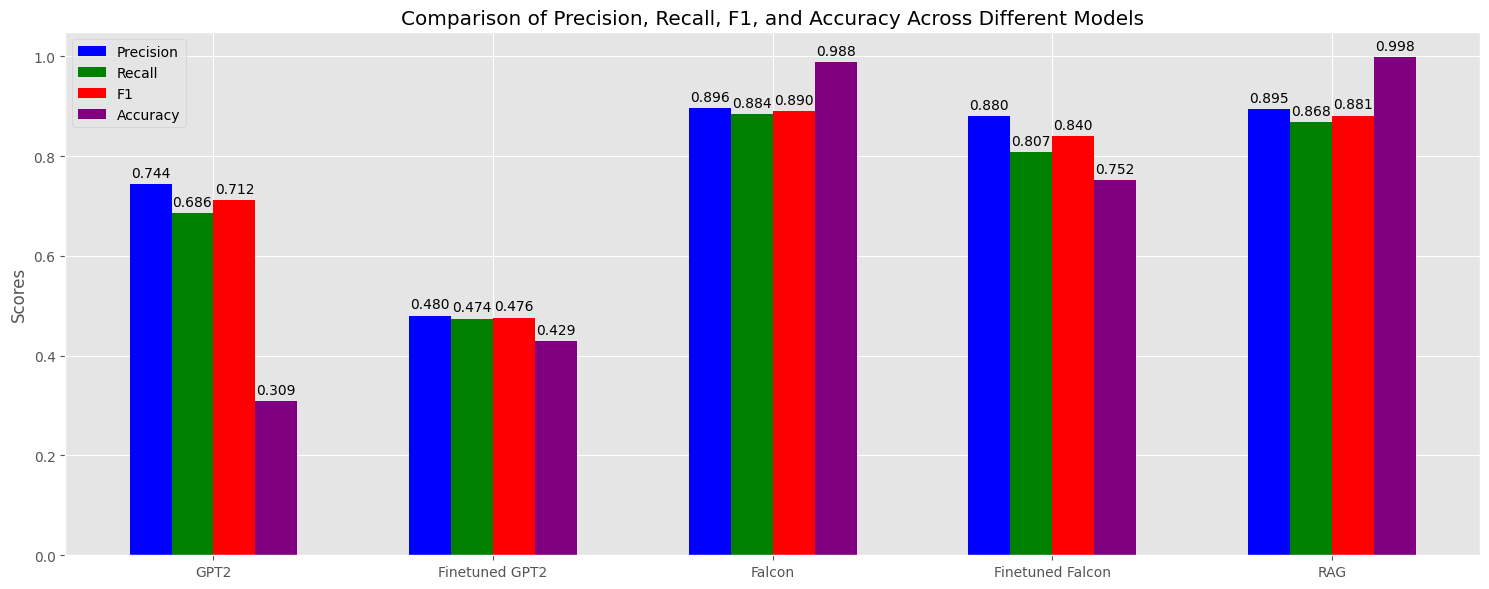

In [20]:


precisions = [average_precision_gpt2, average_precision_gpt2_finetune, average_precision_falcon, average_precision_falcon_finetune, average_precision_rag]
recalls = [average_recall_gpt2, average_recall_gpt2_finetune, average_recall_falcon, average_recall_falcon_finetune, average_recall_rag]
f1_scores = [average_f1_gpt2, average_f1_gpt2_finetune, average_f1_falcon, average_f1_falcon_finetune, average_f1_rag]
accuracies = [accuracy_gpt2, accuracy_gpt2_finetune, accuracy_falcon, accuracy_falcon_finetune, accuracy_rag]


labels = ['GPT2', 'Finetuned GPT2', 'Falcon 7B', 'Finetuned Falcon 7B', 'RAG']

x = np.arange(len(labels))
width = 0.15


fig, ax = plt.subplots(figsize=(15, 6))

rects1 = ax.bar(x - 1.5*width, precisions, width, label='Precision', color='blue')
rects2 = ax.bar(x - 0.5*width, recalls, width, label='Recall', color='green')
rects3 = ax.bar(x + 0.5*width, f1_scores, width, label='F1', color='red')
rects4 = ax.bar(x + 1.5*width, accuracies, width, label='Accuracy', color='purple')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision, Recall, F1, and Accuracy Across Different Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

plt.tight_layout()
plt.show()
